<a href="https://colab.research.google.com/github/mbnext/BI_ML_2021/blob/cnn_1/hw_cnn_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 1. Свёртка

**5 баллов**

Реализуйте функцию свёртки `conv(x, kernel, stride, pad)`, где:


* $\text{x}$: Двумерный массив размером $(W,H)$;
* $\text{kernel}$: ядро свёртки размером $(K, K)$;
* $\text{stride}$: шаг ядра свёртки. $0 < \text{stride} \leq \min(W,H)$;
* $\text{pad}$: ширина дополнения с каждой из сторон массива. $\text{pad} > 0$.

Результатм работы функции является возвращение следующего значения:
* $out$: Результат свертки входных данных $\text{x}$, имеющий размер $(H', W')$: 
  - $H' = 1 + (H + 2 \cdot pad - K)\ //\  stride$;
  - $W' = 1 + (W + 2 \cdot pad - K)\  //\ stride$.

---

Воспользуйтесь созданной функцией `conv` для применения [оператора Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F) 
к изображению, после чего выведите результат на экран.

Можно работать и с `numpy`, и с `torch`, как вам угодно.

In [ ]:
import torch
import numpy as np

In [ ]:
# Можете тренироваться на этом примере
a = np.arange(9).reshape((3, 3))
M = np.block([[a, a],[a, a]])
print(M)

[[0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]
 [0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]]


In [ ]:
def conv(x, kernel, stride, pad):
    # YOUR CODE IS HERE
    x_in_f = np.pad(x, [(pad, pad), (pad, pad)], mode='constant')
    w_convoluted = 1 + (len(x) + 2 * pad - len(kernel)) // stride
    n_convoluted = 1 + (len(x[0]) + 2 * pad - len(kernel)) // stride
    k_len = len(kernel)
    
    resulted_x = np.zeros((w_convoluted, n_convoluted), dtype=int)
    for i in range(0, w_convoluted, stride):
        for j in range(0, n_convoluted, stride):
            resulted_x[i, j] = np.sum(x_in_f[i:i+k_len,j:j+k_len] * kernel)
    
    return resulted_x

In [ ]:
sobel_kernel_vert = torch.Tensor([
                                  [-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]
])


sobel_kernel_hor = torch.Tensor([
                                 [-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]
])

In [ ]:
print(conv(M, sobel_kernel_vert.numpy(), 1, 1))

[[  6   6  -3  -3   6  -6]
 [ 16   8  -4  -4   8 -16]
 [ 19   8  -4  -4   8 -19]
 [ 13   8  -4  -4   8 -13]
 [ 16   8  -4  -4   8 -16]
 [ 18   6  -3  -3   6 -18]]


In [ ]:
print(conv(M, sobel_kernel_hor.numpy(), 1, 1))

[[ 10  16  17  15  16  14]
 [ 18  24  24  24  24  18]
 [ -9 -12 -12 -12 -12  -9]
 [ -9 -12 -12 -12 -12  -9]
 [ 18  24  24  24  24  18]
 [-10 -16 -17 -15 -16 -14]]


Примените эти два фильтра к следующей картинке и нарисуйте полученные результаты:

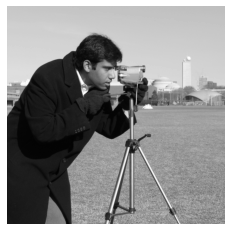

In [ ]:
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
plt.figure()
plt.imshow(camera.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

Допишите код ниже и проинтерпретируйте полученный результат:

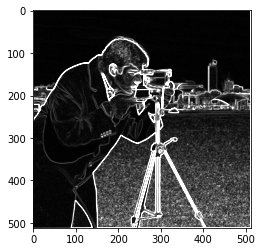

In [ ]:
camera_s_hor_filter = conv(camera, sobel_kernel_hor.numpy(), 1, 1) # результат применения sobel_kernel_hor
camera_s_vert_filter = conv(camera, sobel_kernel_vert.numpy(), 1, 1) # результат применения sobel_kernel_vert
camera_with_borders = np.sqrt(camera_s_hor_filter**2 + camera_s_vert_filter**2)
plt.imshow(camera_with_borders, cmap="gray", vmin=0, vmax=255);

In [ ]:
# все то, что не похоже на горизонтальные и вертикальные линии (по которым фильтруем), затемнилось, а все то, что похоже на гор. или верт. линии, сильно высветлено (там еще и квадрат мы взяли)
# и получается, что обведены явно границы изображенных предметов (а информация по тому, какие где цвета (или скорее оттенки серого) потерялась)

## Задание 2. AlexNet

**15 баллов**

Воссоздайте архитектуру `AlexNet` для определения заболевания растения. Датасеты уже созданы ниже.

In [ ]:
INPUT_IMAGE_SIZE = 227
BATCH_SIZE = 64
N_EPOCHS = 15 # можно будет при желании увеличить (Марианна: и так все висит уже, куда уж больше. Тоже Марианна после аккураси 76% на 10 эпохах: ойвсе, делаю 20)))
# Та же Марианна после роста лосс на 20 эпохе: ну чо ты, норм же общались, пусть будет 15 -_-
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42

In [ ]:
from IPython.display import clear_output

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, ToPILImage
from torchvision.transforms import Normalize, Resize

from glob import glob
from torch import nn
from torch.nn import functional as F
import torch
import os
 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

clear_output()

In [ ]:
!unzip train.zip
!unzip validation.zip
!unzip test.zip

clear_output()

In [ ]:
class BeanDataset(Dataset):
    def __init__(self, img_dir, side_size=INPUT_IMAGE_SIZE):
        # папка с картинками
        self.img_dir = img_dir
        # отсортированный список с названиями файлов
        self.files = sorted(glob(f'{img_dir}/*/*.jpg'))
        class_names = sorted(os.listdir(img_dir))
        # названия папок с картинками переведем в номера классов
        self.class_dir = {name:idx for idx, name in enumerate(class_names)}
        self._number_to_labels = {idx:name for idx, name in enumerate(class_names)}

        # трансформации данных: мы изменяем размер,
        # так как AlexNet работает с картинками 227 на 227 пикселей
        self.transforms = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor(),
                                  Normalize(
                                      mean = [0.5183, 0.4845, 0.6570],
                                      std = [0.2111, 0.2227, 0.2291]
                                  )])
        self._transforms_for_plot = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor()
                                  ])


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx, normalize=True):
        file_path = self.files[idx]
        image = read_image(file_path).type(torch.DoubleTensor)

        # применяем трансформации
        if normalize:
            transformed_img = self.transforms(image)
        
        transformed_img = self._transforms_for_plot(image)
        
        label_name = file_path.split('/')[-2]
        label = self.class_dir[label_name]
        
        # как обычно возвращаем картинку и номер класса
        return transformed_img, label

In [ ]:
train_dataset = BeanDataset("./train/")
valid_dataset = BeanDataset("./validation/")
test_dataset = BeanDataset("./test/")

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Посмотрим на наши картинки:

(код довольно эзотерический, но у меня было такое настроение)

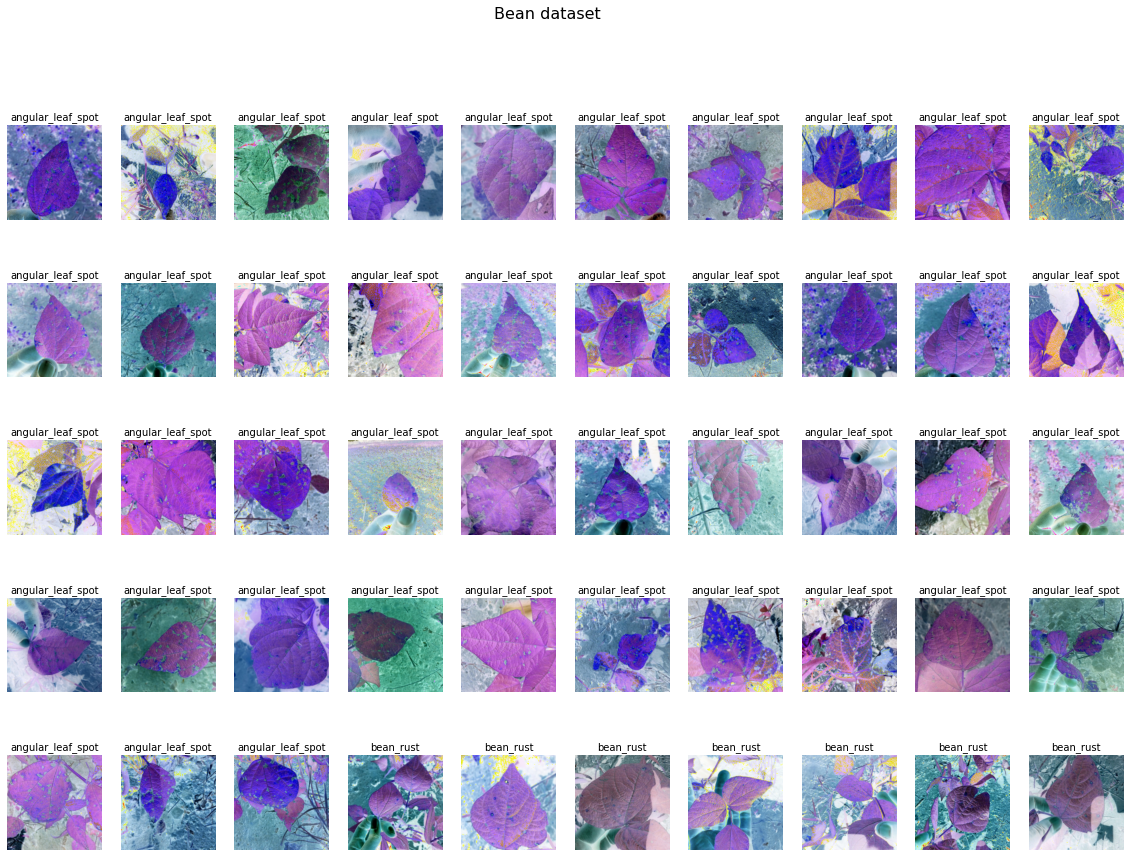

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    title = valid_dataset._number_to_labels[valid_dataset.__getitem__(index, normalize=False)[1]]
    plt.title(title, fontsize=10)
    
fig.suptitle("Bean dataset", fontsize=16);

### Реализация `AlexNet`

В лекции мы познакомились с архитектурой `AlexNet`, теперь пришло время реализовать ее самостоятельно. Важно, что на выходе число классов у нас будет сильно меньше чем 1000, нужно будет в начале это определить. Везде в качестве активации используется `ReLU`.

Также обратите внимание на параметры пулинга, тут ядро 3х3 со страйдом 2 (поэтому он называется overlapping).

Картинка может немного отличаться от того, что было на лекции, ориентируйтесь на картинку в ноутбуке.

Внимательно смотрите на параметры сверток (например, padding / stride).

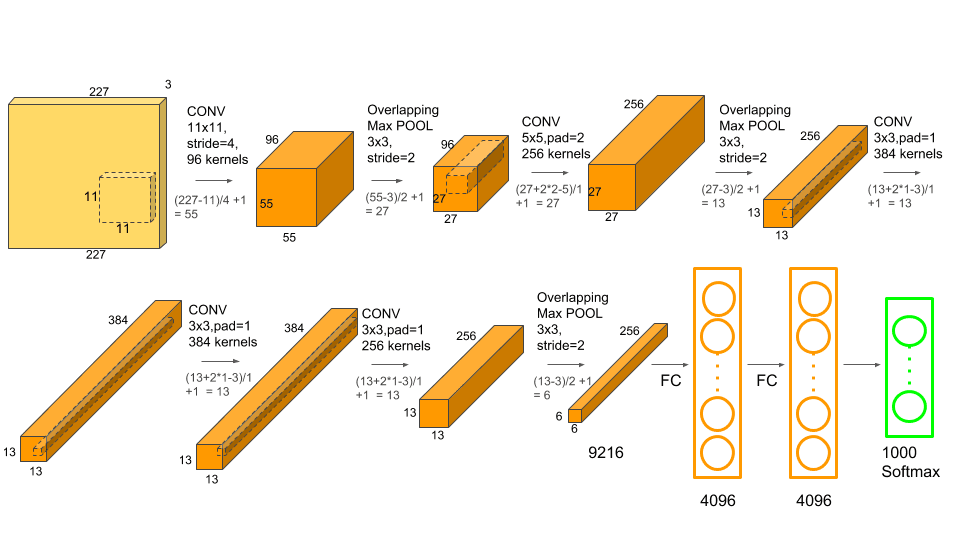

In [ ]:
! ls -lah # немного мудильни с определением числа классов, я решила просто посмотреть на то, что там в итоге накачалось

total 172M
drwxr-xr-x 1 root root 4.0K Apr 17 18:32 .
drwxr-xr-x 1 root root 4.0K Apr 17 18:16 ..
drwxr-xr-x 1 root root 4.0K Apr  8 13:31 .config
drwxr-xr-x 1 root root 4.0K Apr  8 13:32 sample_data
drwxr-xr-x 5 root root 4.0K Jan 22  2020 test
-rw-r--r-- 1 root root  17M Jan 22  2020 test.zip
drwxr-xr-x 5 root root 4.0K Jan 22  2020 train
-rw-r--r-- 1 root root 138M Jan 22  2020 train.zip
drwxr-xr-x 5 root root 4.0K Jan 22  2020 validation
-rw-r--r-- 1 root root  18M Jan 22  2020 validation.zip


In [ ]:
ls ./train/ # тут 3

angular_leaf_spot/  bean_rust/  healthy/


In [ ]:
ls ./validation/ # тут 3

angular_leaf_spot/  bean_rust/  healthy/


In [ ]:
! ls ./test/ # и тут 3

angular_leaf_spot  bean_rust  healthy


In [ ]:
N_CLASSES = 3 # определите число классов в данных 
LEARNING_RATE = 3e-4 # можно подобрать как-то другой)

In [ ]:
from torch.nn.modules.activation import Softmax
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE IS HERE
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),           
            
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(),
            
            nn.Linear(4096, 4096),
            nn.ReLU(),
            
            nn.Linear(4096, N_CLASSES)
        )

    def forward(self,x):
        # YOUR CODE IS HERE
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)

        return logits, probs

Возьмите код для обучения и валидации модели, который был на лекции (если захочется, то его можно как угодно менять). В лекции мы возвращали из модели помимо логитов еще и вероятности классов, чтобы потом рисовать красивые картинки. Если захотите сделать также, то учтите это.

In [ ]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    """
    Function for the training step of the training loop
    """

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate_epoch(valid_loader, model, criterion, device):
    """
    Function for the validation step of the training loop
    """
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def get_accuracy(model, dataloader, device):
    """
    model - 
    dataloader - 
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy


def plot_losses(train_losses, valid_losses):
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=train_losses, label="Train Loss")
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=valid_losses, label="Validation Loss")


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    """
    Function defining the entire training loop
    """

    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_epoch(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, train_losses, valid_losses

Выберите функцию потерь и оптимизатор и обучите полученную модель на тренировочных данных, параллельно проверяя ее на валидационной части:

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # Оптимизатор 
criterion = nn.CrossEntropyLoss() # Функция потерь

18:33:32 --- Epoch: 0	Train loss: 1.0991	Valid loss: 1.0518	Train accuracy: 39.56	Valid accuracy: 38.35
18:34:15 --- Epoch: 1	Train loss: 1.0260	Valid loss: 1.0197	Train accuracy: 42.84	Valid accuracy: 42.11
18:34:57 --- Epoch: 2	Train loss: 0.9890	Valid loss: 0.9417	Train accuracy: 51.55	Valid accuracy: 51.13
18:35:42 --- Epoch: 3	Train loss: 0.9407	Valid loss: 0.9067	Train accuracy: 57.35	Valid accuracy: 58.65
18:36:25 --- Epoch: 4	Train loss: 0.8525	Valid loss: 0.8343	Train accuracy: 63.73	Valid accuracy: 62.41
18:37:06 --- Epoch: 5	Train loss: 0.7992	Valid loss: 0.8365	Train accuracy: 56.87	Valid accuracy: 57.89
18:37:48 --- Epoch: 6	Train loss: 0.8001	Valid loss: 0.7244	Train accuracy: 63.44	Valid accuracy: 63.16
18:38:30 --- Epoch: 7	Train loss: 0.7229	Valid loss: 1.6151	Train accuracy: 52.61	Valid accuracy: 54.14
18:39:12 --- Epoch: 8	Train loss: 0.9174	Valid loss: 0.8085	Train accuracy: 69.15	Valid accuracy: 67.67
18:39:54 --- Epoch: 9	Train loss: 0.7373	Valid loss: 0.6181	Trai

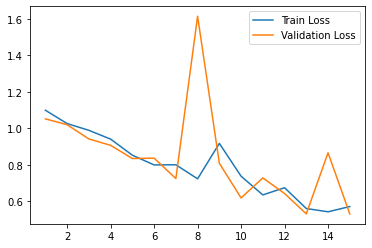

In [ ]:
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

Если вы все реализовали правильно, то `accuracy` на валидации должна быть в районе 0.8.

In [ ]:
# нууу, с натяжкой она стремится к 0,8=)) - это с 10 эпохами
# с 20 эпохами - в общем да, за 80, но последнюю эпоху кажется, переучили (лосс на валидации сильно больше предыдущих, а аккураси - сильно хуже, ок 40-50, хотя возможно, это был какой-то супервыброс)
# с 15 эпохами - ну при повторном запуске с выбросами бывает, но в общем норм, около 80. 

### Визуализация предсказаний

Визуализируем предсказания нашей модели и степень уверенности в них. Сделайте выводы о качестве полученной модели.

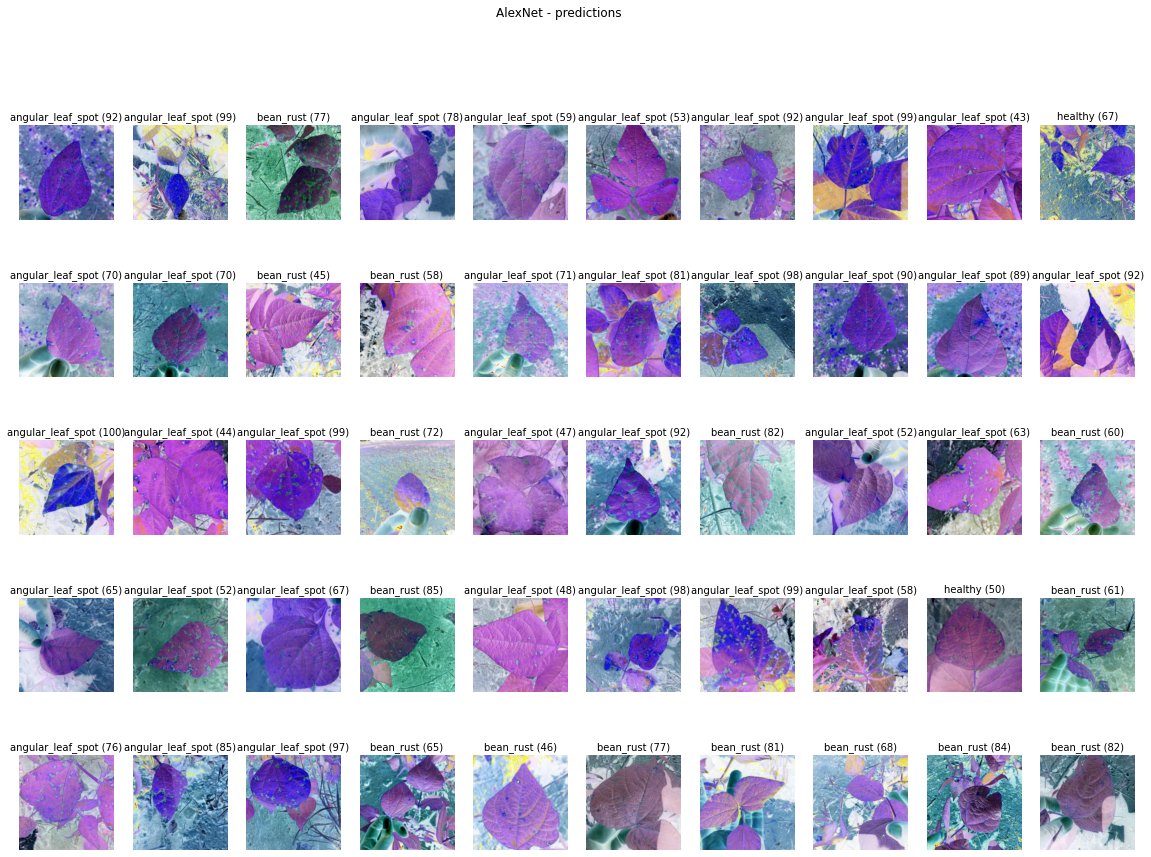

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    
    with torch.no_grad():
        # error)
        model.cpu().eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    title = f"{valid_dataset._number_to_labels[torch.argmax(probs).item()]} ({torch.max(probs * 100):.0f})"
    
    plt.title(title, fontsize=10)
fig.suptitle('AlexNet - predictions');

In [ ]:
# в каких-то случаях модель очень уверена в предсказании, в каких-то уверенность меньше (даже меньше 50 иногда). 
# Я сама не особо разбираюсь в ржавчине бобовых и угловатой пятнистости листьев, поэтому считаю, что модель явно лучше, чем я, может сказать, кто где)

## Задание 3. И снова социализация

**1 дополнительный балл**

Однажды такое уже бывало, но почему бы не повторить. Сходите погулять вместе с одногруппниками или созвонитесь в зуме, а сюда прикрепите какие-нибудь фотографии и кратко опишите, на какие темы вы общались)

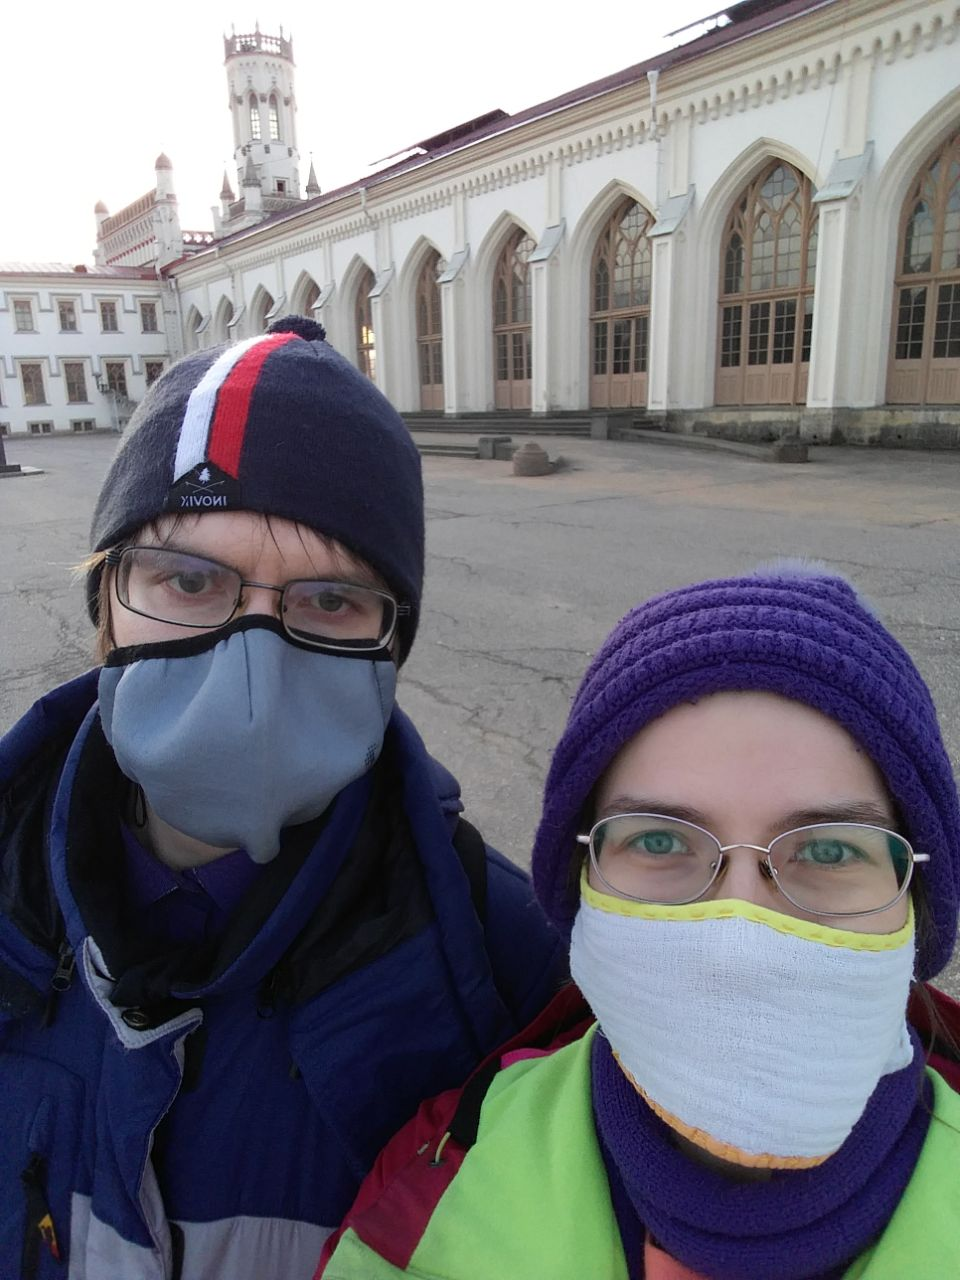

Это читерство, я знаю, но вот вам мы с Димой Поляковым (чот маски сползли -_- ) и старый вокзал Нового Петергофа, после того как мы проводили нашу общую коллегу из Биокада на новое место работы в Москву) катались на картах в PitStop Premium рядом с метро Ладожская, было прикольно, я каталась первый раз в жизни (и машину тоже не вожу), chilling adventure получилось (хотя дороговато, имхо 1200 руб за 15 мин, но м.б. это обычные цены для таких покатушек). 

Тут, как обычно, можно описать свои эмоции от выполнения этого задания:

**Ответ:**

In [ ]:
# подозрительно несложно -_- хотя работа сейчас напала, ну и семестровый проект, все равно времени ни на что не хватает 
#(дада, это говорит человек, который еще ходит куда-то там кататься на карте)-_- 
# еще я завтра первый раз в жизни превозмогаю операцию под наркозом (вроде ничего страшного и все быстро, но все равно как-то стремно -_- 
# я уже всем пожаловалась, пусть и тут по традиции жаловаться на жизнь будет)